In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import pandas as pd

import torch
from preprocessing import *
from experimental_neural_nets import Conv_test, Road_data
from road_correction import process_roads, f1_loss_numpy

In [2]:
# Helper functions


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#imgs,gt_imgs = rotate_train_data(imgs,gt_imgs)
#imgs,gt_imgs = flip_train_data(imgs,gt_imgs)

n = 50  # Only use 10 images for training

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


Image size = 400,400


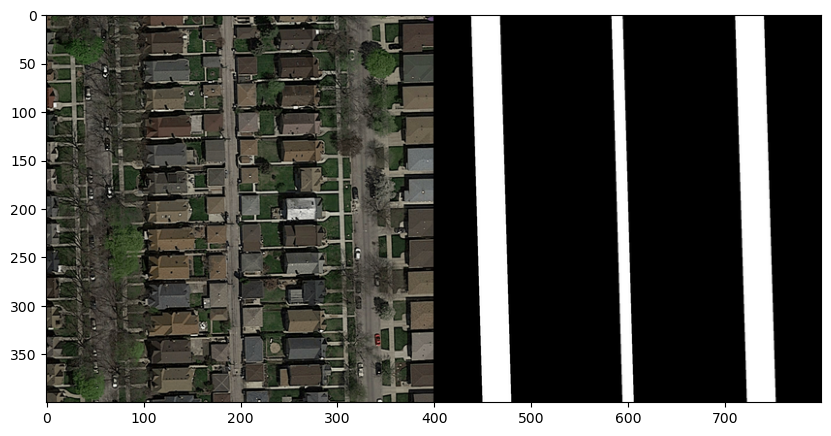

In [4]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

In [5]:
# Extract patches from input images
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

In [6]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0, 1))
    feat_v = np.var(img, axis=(0, 1))
    feat = np.append(feat_m, feat_v)
    return feat


# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat


# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features_2d(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

In [7]:
# Compute features for each image patch
foreground_threshold = (
    0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
)


def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0


X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [8]:
# Print feature statistics

print("Computed " + str(X.shape[0]) + " features")
print("Feature dimension = " + str(X.shape[1]))
print("Number of classes = " + str(np.max(Y)))  # TODO: fix, length(unique(Y))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print("Class 0: " + str(len(Y0)) + " samples")
print("Class 1: " + str(len(Y1)) + " samples")

Computed 31250 features
Feature dimension = 2
Number of classes = 1
Class 0: 23169 samples
Class 1: 8081 samples


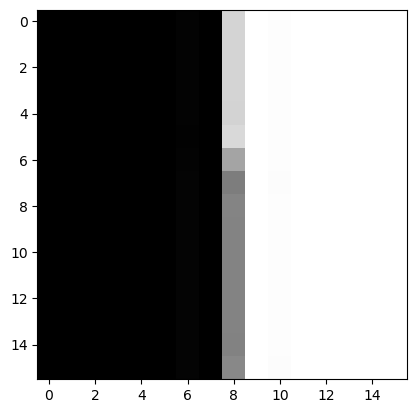

In [9]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap="Greys_r")

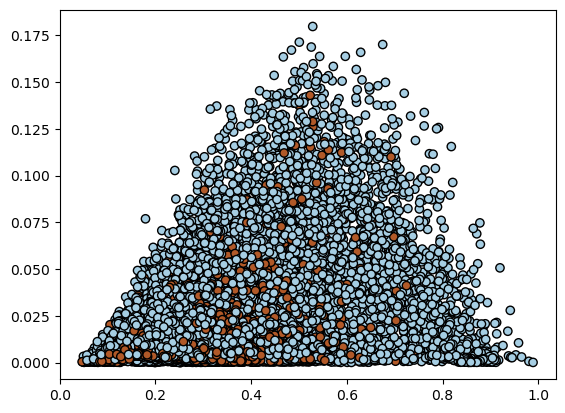

In [10]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)

In [11]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced')

In [12]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print("True positive rate = " + str(TPR))

True positive rate = 0.181888


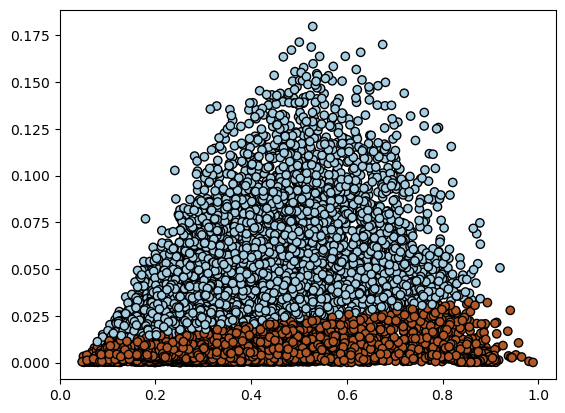

In [13]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors="k", cmap=plt.cm.Paired)

In [14]:
# Convert array of labels to an image


def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

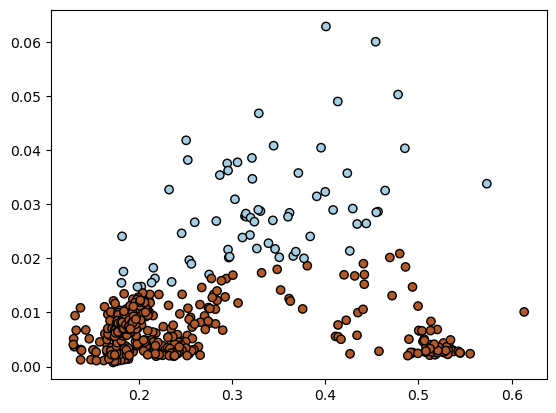

In [15]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors="k", cmap=plt.cm.Paired)

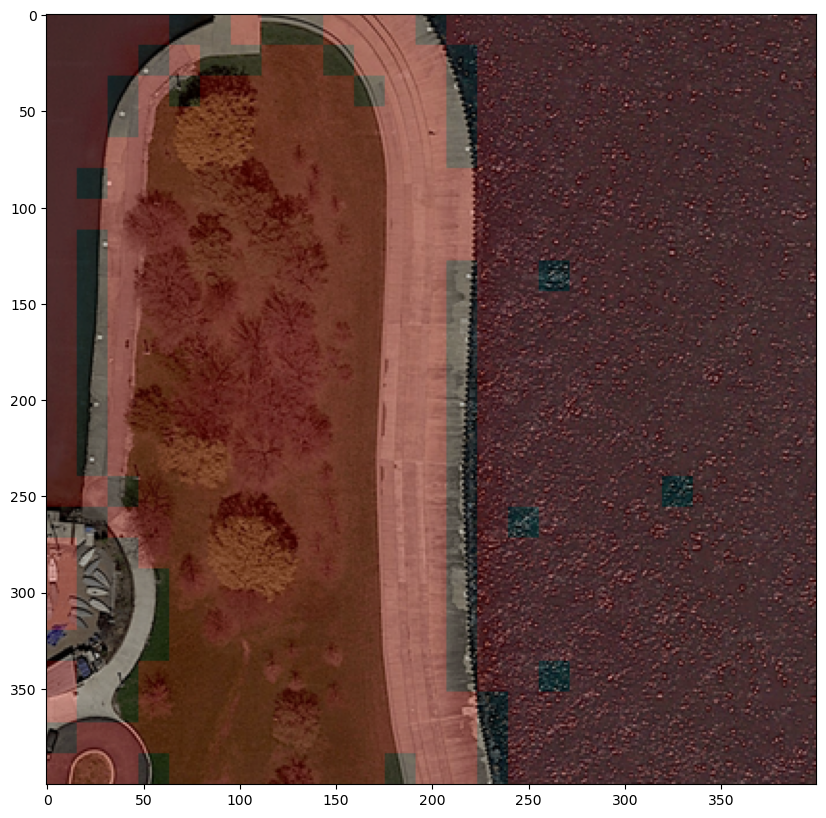

In [16]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

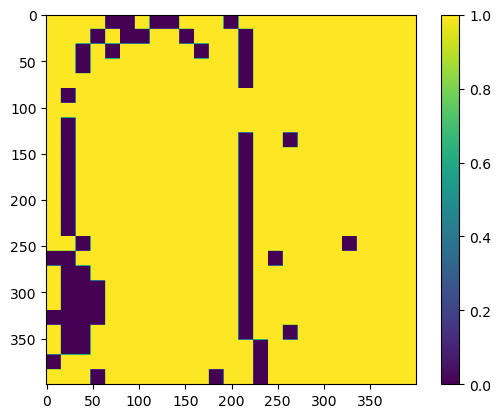

In [17]:
plt.imshow(predicted_im)
plt.colorbar()

In [18]:
list_param_dict = [
    {'out_channels': 8, 'kernel_size': 15, 'stride': 1, 'padding': 7},
    {'out_channels': 16, 'kernel_size': 7, 'stride': 1, 'padding': 3},
    {'out_channels': 32, 'kernel_size': 5, 'stride': 1, 'padding': 2},
    {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ]
skip_list = None
skip_targets = None

In [19]:
print(imgs[0].shape)
print(gt_imgs[0].shape)

(400, 400, 3)
(400, 400)


In [20]:
model = Conv_test(in_channels=3,
                  list_conv_param=list_param_dict,
                  skip_list_C=skip_list,
                  skip_targets_C=skip_targets)

In [ ]:
from torch.utils.data import DataLoader

num_epochs = 5

dataset = Road_data(imgs,gt_imgs)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(dataloader):

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/5, Loss: 0.7879
Epoch 2/5, Loss: 0.7594
Epoch 3/5, Loss: 0.7569


In [ ]:
import os
import re

# Define the root directory containing the test image folders
test_dir = "data/test_set_images/"

# Helper function to perform natural sorting
def natural_sort_key(s):
    # Extract numbers from the string for sorting
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# List all subdirectories (each containing one image) and sort them naturally
test_folders = sorted(
    [folder for folder in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, folder))],
    key=natural_sort_key
)

# Calculate the number of test images (based on the number of folders)
n_test = len(test_folders)
print("Loading " + str(n_test) + " images")

# Iterate over each folder, find the image, and load it
test_imgs = []
for folder in test_folders:
    folder_path = os.path.join(test_dir, folder)
    
    # List all files in the folder (assuming only one image per folder) and sort them naturally
    image_files = sorted(
        [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))],
        key=natural_sort_key
    )
    
    # Assuming there's only one image per folder, get the image file path
    if image_files:
        image_path = os.path.join(folder_path, image_files[0])
        test_imgs.append(load_image(image_path))


In [ ]:
test_imgs = np.array(imgs[:5])
true_targets = (np.array(gt_imgs[:5]) > 0).astype(np.uint8)
#prediction using the model
images = torch.from_numpy(test_imgs).permute(0, 3, 1, 2)
pred = model(images)
pred_np = pred.detach().cpu().numpy()

loss = np.inf
best_t = 0
for threshold in np.linspace(0.01,0.99,100):
    c_pred = []
    for i in range(len(pred_np)):
        c_pred.append(process_roads(pred_np[i],threshold=0.4,display=False))
    c_loss = f1_loss_numpy(np.array(c_pred),true_targets)
    if c_loss < loss:
        loss = c_loss
        best_t = threshold

final_pred = []
for i in range(len(pred_np)):
        final_pred.append(process_roads(pred_np[i],threshold=0.4,display=True))


for i in range(len(pred_np)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))
    prediction=final_pred[i]
    axes[0].imshow(prediction, cmap='gray')
    axes[0].set_title("Prediction")
    
    axes[1].imshow(pred_np[i], cmap='gray')
    axes[1].set_title("Probability map")

    img_np = images[i].permute(1, 2, 0).cpu().numpy() 

    axes[2].imshow(img_np)
    axes[2].set_title("Original Image")

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")

    plt.show()
    


In [ ]:
from mask_to_submission import *

threshold = 0.01

def getting_sub (prediction):
    output_dir = 'predictions_KNN'
    os.makedirs(output_dir, exist_ok=True)

    # Save each prediction as an image
    pred_filenames = []
    for i in range(prediction.shape[0]):
        pred_mask = (prediction[i] > threshold).astype(np.uint8)  # Example thresholding, modify as needed
        pred_image = Image.fromarray(pred_mask * 255)  # Save the mask as a black and white image
        filename = os.path.join(output_dir, f"prediction_{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    # Now you can call the masks_to_submission function with the generated file paths
    submission_filename = 'KNN_try.csv'
    masks_to_submission(submission_filename, *pred_filenames)
    
import numpy as np
from PIL import Image
import os

def getting_sub_patching (prediction, patch_size=16, threshold=0.1):
    output_dir = 'predictions_KNN'
    os.makedirs(output_dir, exist_ok=True)

    # Save each prediction as an image
    pred_filenames = []
    for i in range(prediction.shape[0]):
        # Initialize an empty mask to modify
        modified_mask = np.zeros_like(prediction[i], dtype=np.uint8)

        # Iterate over the image in 16x16 patches
        for y in range(0, prediction.shape[1], patch_size):
            for x in range(0, prediction.shape[2], patch_size):
                # Get the current 16x16 patch
                patch = prediction[i, y:y+patch_size, x:x+patch_size]

                # Calculate the mean of the patch
                patch_mean = np.mean(patch)

                # If the mean of the patch is greater than the threshold, set it to 1 (or another value)
                if patch_mean > threshold:
                    modified_mask[y:y+patch_size, x:x+patch_size] = 1  # Change the patch to 1, or set it to other value

        # Save the modified mask as an image
        pred_image = Image.fromarray(modified_mask * 255)  # Convert to 0-255 scale for image
        filename = os.path.join(output_dir, f"prediction_{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    # Now you can call the masks_to_submission function with the generated file paths
    submission_filename = 'KNN_patching.csv'
    masks_to_submission(submission_filename, *pred_filenames)

# Example usage:
# Assume pred_np is a NumPy array of shape (num_images, height, width) with your predictions
# getting_sub(pred_np)


getting_sub(pred_np)

In [ ]:
image = torch.tensor(imgs[0:20]).permute(0,3, 1, 2)
pred = model(image)
pred_np = pred.detach().cpu().numpy()


num_images = pred_np.shape[0]
for i in range(len(pred_np)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

    axes[0].imshow(pred_np[i], cmap='gray')
    axes[0].set_title("Prediction")
    
    axes[1].imshow(gt_imgs[i], cmap='gray')
    axes[1].set_title("Prediction")

    img_np = image[i].permute(1, 2, 0).cpu().numpy() 

    axes[2].imshow(img_np)
    axes[2].set_title("Original Image")

    axes[0].axis("off")
    axes[1].axis("off")
    axes[2].axis("off")

    plt.show()